In [3]:
import numpy as np
from matplotlib import pyplot as py
import math
%matplotlib inline
from scipy import integrate

u_inf = 1.0

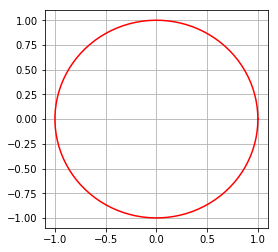

In [4]:
#define cylinder with unit radius

R = 1.0
x_center, y_center = 0.0, 0.0
theta = np.linspace(0.0, 2*math.pi, 100)
x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                         y_center + R * np.sin(theta))

#plot cylinder
size = 4
py.figure(figsize=(size, size))
py.grid()
py.plot(x_cylinder, y_cylinder, color = 'r');

In [5]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2 #center point
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2) #length of panel
        
        #orientation of panel
        if xb - xa <= 0.0:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
            
        self.sigma = 0.0 # source strength
        self.vt = 0.0 #tangential velocity
        self.cp = 0.0 #pressure coefficient
            

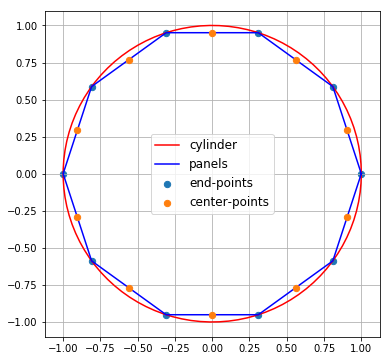

In [7]:
N_panels = 10 #number of desired panels

# define end-points of the panels
x_ends = R * np.cos(np.linspace(0.0, 2 * math.pi, N_panels + 1))
y_ends = R * np.sin(np.linspace(0.0, 2 * math.pi, N_panels + 1))

#define panels
panels = np.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
# plot panels
size = 6
py.figure(figsize=(size,size))
py.grid()
py.plot(x_cylinder, y_cylinder, label='cylinder', color = 'r')
py.plot(x_ends, y_ends, label='panels', color = 'b')
py.scatter([p.xa for p in panels], [p.ya for p in panels],
          label = 'end-points', s=40)
py.scatter([p.xc for p in panels], [p.yc for p in panels],
          label='center-points', s=40, zorder=3)
py.legend(loc='best', prop={'size':12});

In [10]:
# we need to make a function that finds the contribution of a panel
# at the center-point of another, in the normal direction.

def integral_normal(p_i, p_j):
    
    def integrand(s):
        return (((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.cos(p_i.beta) + 
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) *math.sin(p_i.beta)) / 
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 + 
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]

In [11]:
#now, we're going to solve the linear equation A*sigma = b
# compute the source influence matrix (A)

A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / math.pi * integral_normal(p_i, p_j)
            
# compute the RHS (b) of the linear system
b = - u_inf * np.cos([p.beta for p in panels])

In [12]:
#now, we can easily solve the linear system using linalg solve function.
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [13]:
#now we can show pressure coeefficient on surface of cylinder
#we create a function using the integrals derived in the lesson
#using quad

def integral_tangential(p_i, p_j):
    
    def integrand(s):
        return ((-(p_i.xc - (p_j.xa - math.sin(p_j.beta) * s)) * math.sin(p_i.beta) +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s)) * math.cos(p_i.beta)) /
                ((p_i.xc - (p_j.xa - math.sin(p_j.beta) * s))**2 +
                 (p_i.yc - (p_j.ya + math.cos(p_j.beta) * s))**2))
    return integrate.quad(integrand, 0.0, p_j.length)[0]


In [14]:
#compute the matrix of the linear system
A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i, j] = 0.5 / math.pi * integral_tangential(p_i, p_j)
            
#compute the RHS (b) of system
b = - u_inf * np.sin([panel.beta for panel in panels])

#compute tangential velocity at each panel center
vt = np.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [15]:
#now you can calculate the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt / u_inf)**2

In [ ]:
#create mesh grid
